<a href="https://colab.research.google.com/github/quangkhai5122/Dectection-Roof/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Đọc dữ liệu
Đọc ảnh images được lấy từ ảnh vệ tinh, các ảnh được lấy mẫu hầu hết ở các tỉnh ngoại thành, và một vài ảnh ở khu vực đông dân cư (dữ liệu được lấy từ https://earth.google.com/web).

Em có sử dụng các ứng dụng để vẽ được polygon mái nhà như `labelme` (file json) sau đó đọc ảnh bằng cv2 lưu các mái nhà dưới dạng ảnh nhị phân bitmask.

In [1]:
!pip install segmentation_models
!pip install albumentations
!pip install --upgrade scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 833.3 kB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import joblib
import imageio
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import random
import segmentation_models as sm
import keras
from tensorflow.keras.optimizers import Adam
sm.set_framework('tf.keras')
from tensorflow.keras.callbacks import ModelCheckpoint
import segmentation_models as sm
import albumentations as A
import cv2
from skimage.measure import regionprops
from sklearn.ensemble import RandomForestClassifier
from skimage.segmentation import slic
from skimage.feature import graycomatrix, graycoprops
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras import layers, models
from skimage.color import rgb2hsv
from skimage.filters import sobel
from sklearn.metrics import jaccard_score, classification_report
from xgboost import XGBClassifier
from sklearn.svm import SVC

Segmentation Models: using `keras` framework.


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# reading the data
project_path = "/content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof"
images_path = os.path.join(project_path, "Data/images_vn/")
labels_path = os.path.join(project_path, "Data/labels_vn/")
images_list = sorted(os.listdir(images_path))
labels_list = sorted(os.listdir(labels_path))
images_dir_list = [images_path+i for i in images_list]
labels_dir_list = [labels_path+i for i in labels_list]

images = []
labels= []

for i in range(len(labels_dir_list)):
    img = imageio.imread(images_dir_list[i])
    bitMask = imageio.imread(labels_dir_list[i])
    bitMask = np.where(bitMask>0,1,0) # convert to binary mask
    images.append(img[:,:,:3]/255.) # remove the alpha channel
    labels.append(bitMask.reshape((256,256,1)))

images, labels = np.array(images), np.array(labels)

print(images_dir_list)
print(labels_dir_list)

<ipython-input-2-01c0ebefef58>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(images_dir_list[i])
<ipython-input-2-01c0ebefef58>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  bitMask = imageio.imread(labels_dir_list[i])


['/content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/Data/images_vn/01.png', '/content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/Data/images_vn/02.png', '/content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/Data/images_vn/03.png', '/content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/Data/images_vn/04.png', '/content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/Data/images_vn/05.png', '/content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/Data/images_vn/06.png', '/content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/Data/images_vn/07.png', '/content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/Data/images_vn/08.png', '/content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/Data/images_vn/09.png', '/content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/Data/images_vn/10.png', '/content/drive/MyDrive/Colab Notebooks/TTNT_Proj

Vẽ biểu đồ dữ liệu bất kỳ.

/content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/Data/images_vn/70.png /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/Data/labels_vn/70.png


Text(0.5, 1.0, 'Segmentation')

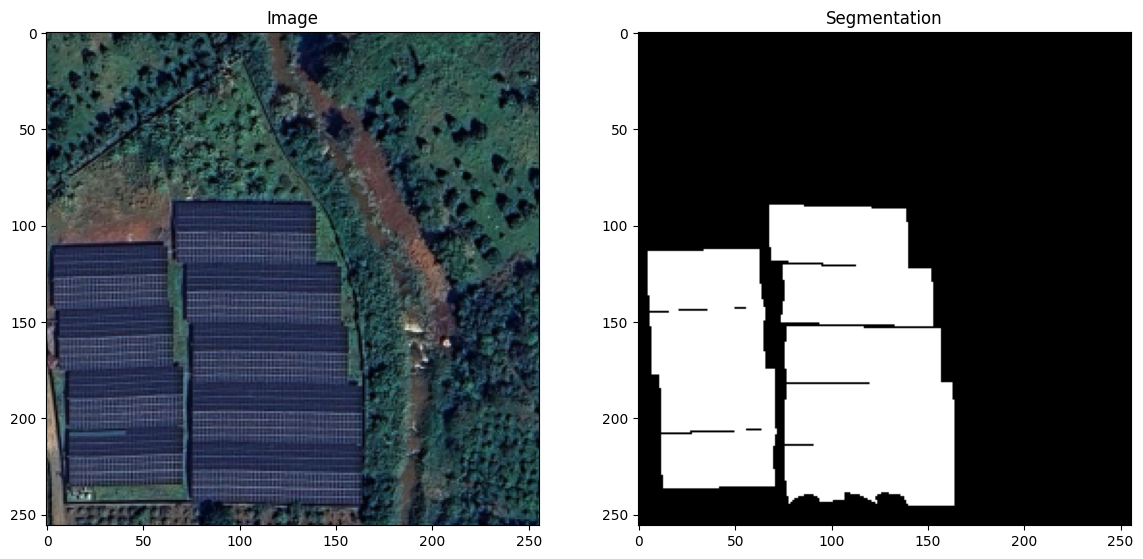

In [3]:
i = np.random.randint(0, len(images_dir_list))
img, lbl = images[i], labels[i]
lbl = lbl.reshape((256,256,1))

print(images_dir_list[i], labels_dir_list[i])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(lbl, cmap='gray')
arr[1].set_title('Segmentation')

# Preprocessing

In [4]:
# Kiểm tra số lượng ảnh và mask có khớp nhau?
print("Số lượng ảnh:", len(images_list))
print("Số lượng mask:", len(labels_list))
assert len(images_list) == len(labels_list), "Số lượng ảnh và mask không khớp!"

# Kiểm tra 5 cặp tên file đầu tiên
print("\n5 cặp ảnh-mask đầu tiên:")
for img_name, mask_name in zip(images_list[:5], labels_list[:5]):
    print(f"Ảnh: {img_name} | Mask: {mask_name}")
    assert img_name.split(".")[0] == mask_name.split(".")[0], "Tên file không khớp!"

Số lượng ảnh: 80
Số lượng mask: 80

5 cặp ảnh-mask đầu tiên:
Ảnh: 01.png | Mask: 01.png
Ảnh: 02.png | Mask: 02.png
Ảnh: 03.png | Mask: 03.png
Ảnh: 04.png | Mask: 04.png
Ảnh: 05.png | Mask: 05.png


In [5]:
# Chuyển đổi sang float32 để tương thích với GPU
images = images.astype(np.float32)
labels = labels.astype(np.float32)

# Kiểm tra range của pixel (ảnh phải [0,1], mask {0,1})
print("\nRange ảnh:", np.min(images), np.max(images))
print("Giá trị mask unique:", np.unique(labels))


Range ảnh: 0.0 1.0
Giá trị mask unique: [0. 1.]


In [6]:
def get_augmentation_pipeline():
    return A.Compose([
        # Geometric transforms
        A.Rotate(limit=(-90, 90), p=0.8, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=(0.0, 0.2), scale_limit=(0.0, 0.2), rotate_limit=(-30, 30), p=0.8),
        A.RandomResizedCrop(size=(256, 256), scale=(0.6, 1.0), ratio=(0.8, 1.2), p=0.5),

        # Color transforms
        A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=0.3, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.3),
        A.CLAHE(p=0.3),

        # Noise & artifacts
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        A.GridDropout(ratio=0.3, random_offset=True, holes_number_x=3, holes_number_y=3, p=0.3),
        A.CoarseDropout(max_holes=8, max_height=20, max_width=20, p=0.3),

        # Advanced transforms
        A.RandomSunFlare(num_flare_circles_lower=1, src_radius=100, p=0.1),
        A.RandomShadow(num_shadows_lower=1, shadow_dimension=5, p=0.1)
    ], additional_targets={'mask': 'mask'})


In [7]:
# 3. Tạo custom TensorFlow Dataset
class RoofDataset(tf.keras.utils.Sequence):
    def __init__(self, images, masks, batch_size=8, augment=True):
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.augment = augment
        self.aug = get_augmentation_pipeline()

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        # Tính toán chỉ số batch
        start_idx = idx * self.batch_size
        end_idx = (idx + 1) * self.batch_size

        batch_images = self.images[start_idx:end_idx]
        batch_masks = self.masks[start_idx:end_idx]

        augmented_images = []
        augmented_masks = []

        for img, mask in zip(batch_images, batch_masks):
            if self.augment:
                transformed = self.aug(image=img, mask=mask)
                aug_img = transformed['image']
                aug_mask = transformed['mask']
            else:
                aug_img = img
                aug_mask = mask

            augmented_images.append(aug_img)
            augmented_masks.append(aug_mask)

        return np.array(augmented_images), np.array(augmented_masks)

In [8]:
# 5. Chia tập train/test
idx = np.arange(len(images))
train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=42)

X_train, y_train = images[train_idx], labels[train_idx]
X_test,   y_test   = images[val_idx],   labels[val_idx]

In [9]:
batch_size = 8
train_gen = RoofDataset(X_train, y_train, batch_size=batch_size, augment=True)
val_gen   = RoofDataset(X_test,   y_test,   batch_size=batch_size, augment=False)

<ipython-input-6-0fa666e6b7e9>:4: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=(-90, 90), p=0.8, border_mode=cv2.BORDER_CONSTANT, value=0),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-6-0fa666e6b7e9>:17: UserWarning: Argument(s) 'holes_number_x, holes_number_y' are not valid for transform GridDropout
  A.GridDropout(ratio=0.3, random_offset=True, holes_number_x=3, holes_number_y=3, p=0.3),
<ipython-input-6-0fa666e6b7e9>:18: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=20, max_width=20, p=0.3),
<ipython-input-6-0fa666e6b7e9>:21: UserWarning: Argument(s) 'num_flare_circles_lower' are not valid for transform RandomSunFlare
  A.RandomSunFlare(num_flare_circles

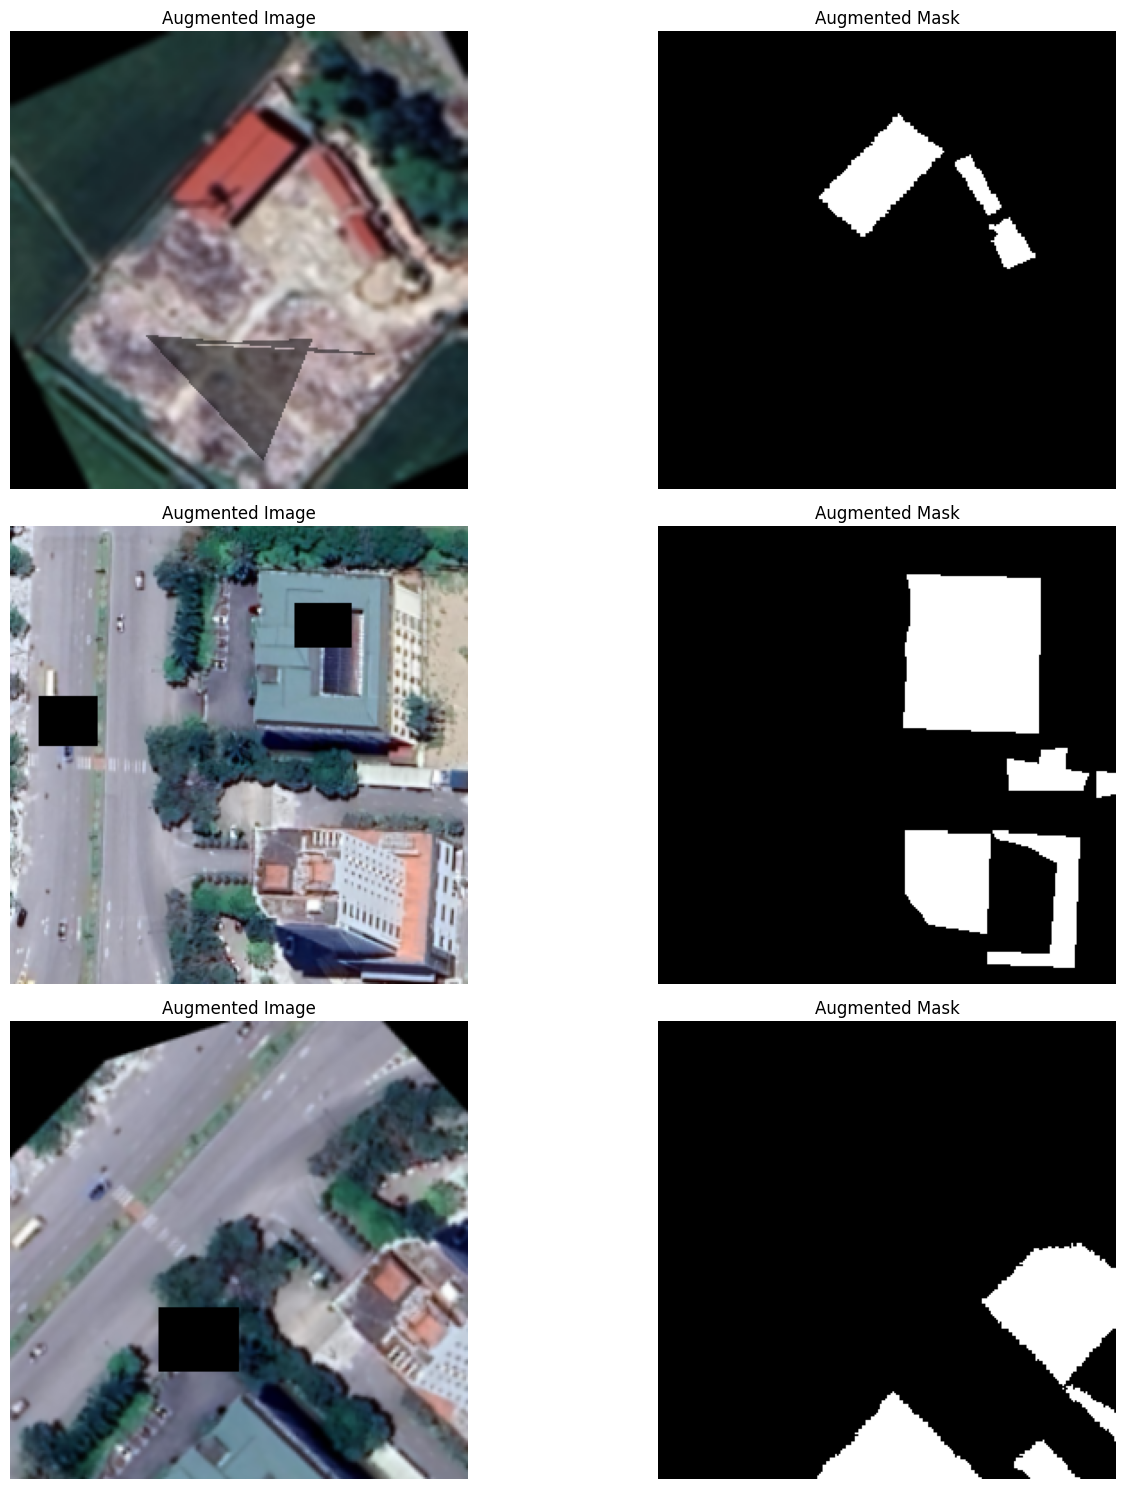

In [10]:
# 7. Kiểm tra augmentation
def visualize_augmentation(dataset, num_samples=3):
    plt.figure(figsize=(15, 5*num_samples))
    for _ in range(num_samples):
        idx = np.random.randint(len(dataset))
        batch_images, batch_masks = dataset[idx]

        plt.subplot(num_samples, 2, 2*_+1)
        plt.imshow(batch_images[0])
        plt.title("Augmented Image")
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*_+2)
        plt.imshow(batch_masks[0].squeeze(), cmap='gray')
        plt.title("Augmented Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_augmentation(train_gen)

In [11]:
# 8. Tạo DataLoader cho training
train_loader = tf.data.Dataset.from_generator(
    lambda: train_gen,
    output_types=(tf.float32, tf.float32),
    output_shapes=((None, 256, 256, 3), (None, 256, 256, 1))
).prefetch(tf.data.AUTOTUNE)

val_loader = tf.data.Dataset.from_generator(
    lambda: val_gen,
    output_types=(tf.float32, tf.float32),
    output_shapes=((None, 256, 256, 3), (None, 256, 256, 1))
).prefetch(tf.data.AUTOTUNE)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [12]:
def extract_pixel_features(img):
    # img: float32, 0–1, shape (256,256,3)
    r, g, b = cv2.split(img)
    h, s, v = rgb2hsv(img).transpose(2,0,1)
    gray = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY) / 255.0
    grad = sobel(gray)
    # Trả về mảng (256,256,7)
    return np.stack([r, g, b, h, s, v, grad], axis=-1)

In [13]:
features_list = [extract_pixel_features(img) for img in images]

In [14]:
# 2. Lấy sample và flatten
samples_per_img = 2000
X_list, y_list = [], []
for feat, mask in zip(features_list, labels):
    H, W, C = feat.shape
    feat_flat = feat.reshape(-1, C)    # (65536, 7)
    mask_flat = mask.reshape(-1)       # (65536,)
    idx = np.random.choice(H*W, samples_per_img, replace=False)
    X_list.append(feat_flat[idx])      # (2000, 7)
    y_list.append(mask_flat[idx])      # (2000,)

In [15]:
# 3. Stack lại thành 2D array
X = np.vstack(X_list)  # (80*2000, 7)
y = np.hstack(y_list)  # (80*2000,)
print("X.shape:", X.shape, "y.shape:", y.shape)

X.shape: (160000, 7) y.shape: (160000,)


In [16]:
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Random Forest Classifier

In [ ]:
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train_ml, y_train_ml)

RandomForestClassifier(max_depth=15, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [ ]:
y_pred_rf = clf.predict(X_test_ml)
print(f"IoU trên tập test: {jaccard_score(y_test_ml, y_pred_rf):.4f}")
print(classification_report(y_test_ml, y_pred_rf, target_names=['background','roof']))


IoU trên tập test: 0.6478
              precision    recall  f1-score   support

  background       0.93      0.98      0.95     25788
        roof       0.88      0.71      0.79      6212

    accuracy                           0.93     32000
   macro avg       0.91      0.84      0.87     32000
weighted avg       0.92      0.93      0.92     32000



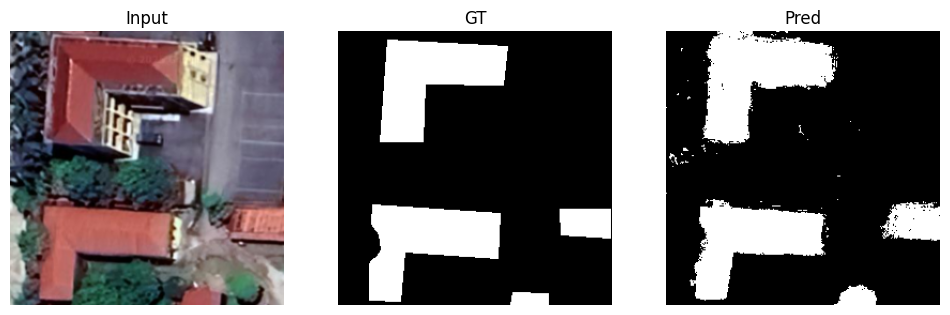

In [ ]:
# Chọn ảnh thử
idx = random.randint(0, len(images) - 1)
img_test_rf = extract_pixel_features(images[idx]).reshape(-1, 7)
pred_rf = clf.predict(img_test_rf).reshape(256,256)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(images[idx]); plt.title("Input"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(labels[idx].squeeze(), cmap='gray'); plt.title("GT"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(pred_rf, cmap='gray'); plt.title("Pred"); plt.axis('off')
plt.show()


In [ ]:
rf_model_path = os.path.join(project_path, "rf.joblib")
joblib.dump(clf, rf_model_path)
print(f"Đã lưu model vào {rf_model_path}")

Đã lưu model vào /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/rf.joblib


# XGBoost

In [ ]:
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train_ml, y_train_ml)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:10:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred_xgb = xgb.predict(X_test_ml)
iou_xgb = jaccard_score(y_test_ml, y_pred_xgb)
print(f"\n[XGBoost] Pixel-wise IoU: {iou_xgb:.4f}")
print("[XGBoost] Classification report:")
print(classification_report(y_test_ml, y_pred_xgb, target_names=['background','roof']))


[XGBoost] Pixel-wise IoU: 0.6438
[XGBoost] Classification report:
              precision    recall  f1-score   support

  background       0.93      0.98      0.95     25788
        roof       0.87      0.71      0.78      6212

    accuracy                           0.92     32000
   macro avg       0.90      0.84      0.87     32000
weighted avg       0.92      0.92      0.92     32000



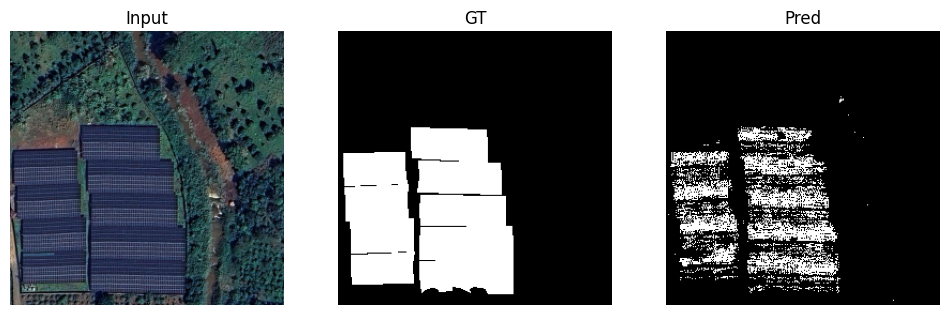

In [ ]:
idx = random.randint(0, len(images) - 1)
img_test_xgb = extract_pixel_features(images[idx]).reshape(-1, 7)
pred_xgb = xgb.predict(img_test_xgb).reshape(256,256)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(images[idx]); plt.title("Input"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(labels[idx].squeeze(), cmap='gray'); plt.title("GT"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(pred_xgb, cmap='gray'); plt.title("Pred"); plt.axis('off')
plt.show()

# Support Vector Machine

In [ ]:
svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=False,
    random_state=42
)
svm.fit(X_train_ml, y_train_ml)

SVC(random_state=42)

In [ ]:
y_pred_svm = svm.predict(X_test_ml)

iou_svm = jaccard_score(y_test_ml, y_pred_svm)
print(f"\n[SVM] Pixel-wise IoU: {iou_svm:.4f}")
print("[SVM] Classification report:")
print(classification_report(y_test_ml, y_pred_svm, target_names=['background','roof']))


[SVM] Pixel-wise IoU: 0.5968
[SVM] Classification report:
              precision    recall  f1-score   support

  background       0.92      0.98      0.95     25788
        roof       0.88      0.65      0.75      6212

    accuracy                           0.91     32000
   macro avg       0.90      0.81      0.85     32000
weighted avg       0.91      0.91      0.91     32000



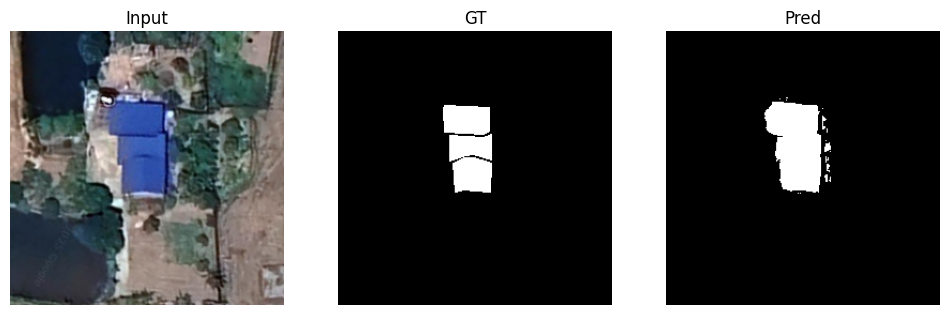

In [ ]:
idx = random.randint(0, len(images) - 1)
img_test_svm = extract_pixel_features(images[idx]).reshape(-1, 7)
pred_svm = svm.predict(img_test_svm).reshape(256,256)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(images[idx]); plt.title("Input"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(labels[idx].squeeze(), cmap='gray'); plt.title("GT"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(pred_svm, cmap='gray'); plt.title("Pred"); plt.axis('off')
plt.show()

# U-Net

In [17]:
# Định nghĩa U-Net đơn giản
def build_unet(input_shape=(256,256,3)):
    inputs = tf.keras.layers.Input(input_shape)
    # Encoder
    def conv_block(x, filters):
        x = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        return x
    c1 = conv_block(inputs, 32)
    p1 = tf.keras.layers.MaxPooling2D()(c1)
    c2 = conv_block(p1, 64)
    p2 = tf.keras.layers.MaxPooling2D()(c2)
    c3 = conv_block(p2, 128)
    p3 = tf.keras.layers.MaxPooling2D()(c3)
    # Bottleneck
    b  = conv_block(p3, 256)
    # Decoder
    def up_block(x, skip, filters):
        x = tf.keras.layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
        x = tf.keras.layers.concatenate([x, skip])
        x = conv_block(x, filters)
        return x
    u3 = up_block(b,  c3, 128)
    u2 = up_block(u3, c2, 64)
    u1 = up_block(u2, c1, 32)
    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(u1)
    return tf.keras.Model(inputs, outputs)

model = build_unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    131,200 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │     32,832 │ conv2d_9[0][0]  

 Total params: 1,925,601 (7.35 MB)

 Trainable params: 1,925,601 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Compile với loss + metric
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return (2*inter + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=[dice_coef]
)

In [20]:
# Callbacks: LR reduction, early stop, save best
unet_model_path = os.path.join(project_path, "unet.h5")
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        unet_model_path, monitor='val_dice_coef', mode='max',
        save_best_only=True, verbose=1
    )
]

In [21]:
# Train
epochs = 100
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - dice_coef: 0.2837 - loss: 0.6803 
Epoch 1: val_dice_coef improved from -inf to 0.28059, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 131s 15s/step - dice_coef: 0.2841 - loss: 0.6800 - val_dice_coef: 0.2806 - val_loss: 0.6638 - learning_rate: 1.0000e-04
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.3054 - loss: 0.6660 
Epoch 2: val_dice_coef did not improve from 0.28059
8/8 ━━━━━━━━━━━━━━━━━━━━ 136s 15s/step - dice_coef: 0.3035 - loss: 0.6653 - val_dice_coef: 0.2749 - val_loss: 0.6401 - learning_rate: 1.0000e-04
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.2873 - loss: 0.6449 
Epoch 3: val_dice_coef did not improve from 0.28059
8/8 ━━━━━━━━━━━━━━━━━━━━ 113s 14s/step - dice_coef: 0.2866 - loss: 0.6433 - val_dice_coef: 0.2451 - val_loss: 0.5692 - learning_rate: 1.0000e-04
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.2160 - loss: 0.5860 
Epoch 4: val_dice_coef did not improve from 0.28059
8/8 ━━━━━━━━━━━━━━━━━━━━ 114s 14s/step - dice_coef: 0.2148 - loss: 0.5850 - val_dice_coef: 0.1985 - val_loss: 0.5386 - learning_rate: 1.0000e-04
Epoch 5/1

8/8 ━━━━━━━━━━━━━━━━━━━━ 119s 15s/step - dice_coef: 0.3220 - loss: 0.4080 - val_dice_coef: 0.2957 - val_loss: 0.4292 - learning_rate: 1.0000e-04
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.3677 - loss: 0.4023 
Epoch 13: val_dice_coef improved from 0.29571 to 0.29733, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 15s/step - dice_coef: 0.3660 - loss: 0.4015 - val_dice_coef: 0.2973 - val_loss: 0.4409 - learning_rate: 1.0000e-04
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.3606 - loss: 0.3630 
Epoch 14: val_dice_coef improved from 0.29733 to 0.31972, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 142s 15s/step - dice_coef: 0.3606 - loss: 0.3667 - val_dice_coef: 0.3197 - val_loss: 0.4113 - learning_rate: 1.0000e-04
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.3711 - loss: 0.3641 
Epoch 15: val_dice_coef did not improve from 0.31972
8/8 ━━━━━━━━━━━━━━━━━━━━ 115s 15s/step - dice_coef: 0.3722 - loss: 0.3656 - val_dice_coef: 0.3174 - val_loss: 0.4278 - learning_rate: 1.0000e-04
Epoch 16/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.3876 - loss: 0.4038 
Epoch 16: val_dice_coef improved from 0.31972 to 0.34332, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 111s 14s/step - dice_coef: 0.3863 - loss: 0.4021 - val_dice_coef: 0.3433 - val_loss: 0.3952 - learning_rate: 1.0000e-04
Epoch 17/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.4030 - loss: 0.3799 
Epoch 17: val_dice_coef improved from 0.34332 to 0.34740, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 148s 15s/step - dice_coef: 0.4019 - loss: 0.3773 - val_dice_coef: 0.3474 - val_loss: 0.3852 - learning_rate: 1.0000e-04
Epoch 18/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.3960 - loss: 0.3703 
Epoch 18: val_dice_coef improved from 0.34740 to 0.35488, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 15s/step - dice_coef: 0.3969 - loss: 0.3692 - val_dice_coef: 0.3549 - val_loss: 0.3839 - learning_rate: 1.0000e-04
Epoch 19/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.4203 - loss: 0.3438 
Epoch 19: val_dice_coef improved from 0.35488 to 0.35708, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 15s/step - dice_coef: 0.4203 - loss: 0.3431 - val_dice_coef: 0.3571 - val_loss: 0.3963 - learning_rate: 1.0000e-04
Epoch 20/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.4480 - loss: 0.3212 
Epoch 20: val_dice_coef improved from 0.35708 to 0.38726, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 15s/step - dice_coef: 0.4465 - loss: 0.3218 - val_dice_coef: 0.3873 - val_loss: 0.3588 - learning_rate: 1.0000e-04
Epoch 21/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.4477 - loss: 0.3471 
Epoch 21: val_dice_coef improved from 0.38726 to 0.38931, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 116s 15s/step - dice_coef: 0.4471 - loss: 0.3461 - val_dice_coef: 0.3893 - val_loss: 0.3556 - learning_rate: 1.0000e-04
Epoch 22/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - dice_coef: 0.4503 - loss: 0.3653 
Epoch 22: val_dice_coef did not improve from 0.38931
8/8 ━━━━━━━━━━━━━━━━━━━━ 122s 15s/step - dice_coef: 0.4492 - loss: 0.3616 - val_dice_coef: 0.3630 - val_loss: 0.4346 - learning_rate: 1.0000e-04
Epoch 23/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.4352 - loss: 0.3746 
Epoch 23: val_dice_coef did not improve from 0.38931
8/8 ━━━━━━━━━━━━━━━━━━━━ 115s 15s/step - dice_coef: 0.4339 - loss: 0.3720 - val_dice_coef: 0.3810 - val_loss: 0.3850 - learning_rate: 1.0000e-04
Epoch 24/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.4745 - loss: 0.3083 
Epoch 24: val_dice_coef did not improve from 0.38931
8/8 ━━━━━━━━━━━━━━━━━━━━ 111s 14s/step - dice_coef: 0.4726 - loss: 0.3103 - val_dice_coef: 0.3868 - val_loss: 0.3847 - learning_rate: 1.0000e-04
Epo

8/8 ━━━━━━━━━━━━━━━━━━━━ 147s 15s/step - dice_coef: 0.4609 - loss: 0.3444 - val_dice_coef: 0.4146 - val_loss: 0.3439 - learning_rate: 1.0000e-04
Epoch 26/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.4994 - loss: 0.2865 
Epoch 26: val_dice_coef improved from 0.41460 to 0.43152, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 15s/step - dice_coef: 0.4982 - loss: 0.2876 - val_dice_coef: 0.4315 - val_loss: 0.3470 - learning_rate: 1.0000e-04
Epoch 27/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.5075 - loss: 0.3209 
Epoch 27: val_dice_coef improved from 0.43152 to 0.47683, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 15s/step - dice_coef: 0.5079 - loss: 0.3176 - val_dice_coef: 0.4768 - val_loss: 0.3314 - learning_rate: 1.0000e-04
Epoch 28/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.5466 - loss: 0.2723 
Epoch 28: val_dice_coef improved from 0.47683 to 0.54104, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 118s 15s/step - dice_coef: 0.5487 - loss: 0.2741 - val_dice_coef: 0.5410 - val_loss: 0.3142 - learning_rate: 1.0000e-04
Epoch 29/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6198 - loss: 0.2812 
Epoch 29: val_dice_coef did not improve from 0.54104
8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 15s/step - dice_coef: 0.6174 - loss: 0.2807 - val_dice_coef: 0.5298 - val_loss: 0.3271 - learning_rate: 1.0000e-04
Epoch 30/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6266 - loss: 0.2624 
Epoch 30: val_dice_coef improved from 0.54104 to 0.55180, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 113s 14s/step - dice_coef: 0.6247 - loss: 0.2650 - val_dice_coef: 0.5518 - val_loss: 0.3214 - learning_rate: 1.0000e-04
Epoch 31/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6064 - loss: 0.2571 
Epoch 31: val_dice_coef did not improve from 0.55180
8/8 ━━━━━━━━━━━━━━━━━━━━ 114s 14s/step - dice_coef: 0.6064 - loss: 0.2573 - val_dice_coef: 0.5239 - val_loss: 0.3108 - learning_rate: 1.0000e-04
Epoch 32/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.5930 - loss: 0.2840 
Epoch 32: val_dice_coef improved from 0.55180 to 0.55607, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 116s 15s/step - dice_coef: 0.5936 - loss: 0.2841 - val_dice_coef: 0.5561 - val_loss: 0.3164 - learning_rate: 1.0000e-04
Epoch 33/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - dice_coef: 0.6519 - loss: 0.2510 
Epoch 33: val_dice_coef did not improve from 0.55607
8/8 ━━━━━━━━━━━━━━━━━━━━ 118s 15s/step - dice_coef: 0.6504 - loss: 0.2529 - val_dice_coef: 0.5472 - val_loss: 0.3203 - learning_rate: 1.0000e-04
Epoch 34/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6028 - loss: 0.2733 
Epoch 34: val_dice_coef did not improve from 0.55607
8/8 ━━━━━━━━━━━━━━━━━━━━ 112s 14s/step - dice_coef: 0.6050 - loss: 0.2713 - val_dice_coef: 0.5510 - val_loss: 0.3037 - learning_rate: 1.0000e-04
Epoch 35/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6437 - loss: 0.2521 
Epoch 35: val_dice_coef improved from 0.55607 to 0.56864, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 115s 14s/step - dice_coef: 0.6415 - loss: 0.2527 - val_dice_coef: 0.5686 - val_loss: 0.3027 - learning_rate: 1.0000e-04
Epoch 36/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6340 - loss: 0.2405 
Epoch 36: val_dice_coef did not improve from 0.56864
8/8 ━━━━━━━━━━━━━━━━━━━━ 140s 14s/step - dice_coef: 0.6357 - loss: 0.2417 - val_dice_coef: 0.5627 - val_loss: 0.3075 - learning_rate: 1.0000e-04
Epoch 37/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6436 - loss: 0.2354 
Epoch 37: val_dice_coef improved from 0.56864 to 0.56978, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 116s 15s/step - dice_coef: 0.6431 - loss: 0.2372 - val_dice_coef: 0.5698 - val_loss: 0.2993 - learning_rate: 1.0000e-04
Epoch 38/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6160 - loss: 0.2717 
Epoch 38: val_dice_coef did not improve from 0.56978
8/8 ━━━━━━━━━━━━━━━━━━━━ 141s 15s/step - dice_coef: 0.6176 - loss: 0.2691 - val_dice_coef: 0.5688 - val_loss: 0.2966 - learning_rate: 1.0000e-04
Epoch 39/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6497 - loss: 0.2512 
Epoch 39: val_dice_coef improved from 0.56978 to 0.57800, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 141s 14s/step - dice_coef: 0.6495 - loss: 0.2516 - val_dice_coef: 0.5780 - val_loss: 0.3003 - learning_rate: 1.0000e-04
Epoch 40/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6206 - loss: 0.2618 
Epoch 40: val_dice_coef did not improve from 0.57800
8/8 ━━━━━━━━━━━━━━━━━━━━ 113s 14s/step - dice_coef: 0.6213 - loss: 0.2622 - val_dice_coef: 0.5509 - val_loss: 0.3184 - learning_rate: 1.0000e-04
Epoch 41/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6405 - loss: 0.2097 
Epoch 41: val_dice_coef did not improve from 0.57800
8/8 ━━━━━━━━━━━━━━━━━━━━ 115s 14s/step - dice_coef: 0.6401 - loss: 0.2135 - val_dice_coef: 0.5559 - val_loss: 0.3169 - learning_rate: 1.0000e-04
Epoch 42/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6058 - loss: 0.2410 
Epoch 42: val_dice_coef improved from 0.57800 to 0.57869, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 116s 15s/step - dice_coef: 0.6096 - loss: 0.2421 - val_dice_coef: 0.5787 - val_loss: 0.3061 - learning_rate: 1.0000e-04
Epoch 43/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6261 - loss: 0.2648 
Epoch 43: val_dice_coef did not improve from 0.57869
8/8 ━━━━━━━━━━━━━━━━━━━━ 142s 15s/step - dice_coef: 0.6268 - loss: 0.2635 - val_dice_coef: 0.5562 - val_loss: 0.2926 - learning_rate: 1.0000e-04
Epoch 44/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6492 - loss: 0.2708 
Epoch 44: val_dice_coef did not improve from 0.57869
8/8 ━━━━━━━━━━━━━━━━━━━━ 116s 15s/step - dice_coef: 0.6464 - loss: 0.2699 - val_dice_coef: 0.5605 - val_loss: 0.2916 - learning_rate: 1.0000e-04
Epoch 45/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6555 - loss: 0.2316 
Epoch 45: val_dice_coef improved from 0.57869 to 0.58743, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 114s 14s/step - dice_coef: 0.6550 - loss: 0.2333 - val_dice_coef: 0.5874 - val_loss: 0.3129 - learning_rate: 1.0000e-04
Epoch 46/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6648 - loss: 0.2416 
Epoch 46: val_dice_coef did not improve from 0.58743
8/8 ━━━━━━━━━━━━━━━━━━━━ 145s 15s/step - dice_coef: 0.6643 - loss: 0.2419 - val_dice_coef: 0.5745 - val_loss: 0.2955 - learning_rate: 1.0000e-04
Epoch 47/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6137 - loss: 0.2748 
Epoch 47: val_dice_coef did not improve from 0.58743
8/8 ━━━━━━━━━━━━━━━━━━━━ 112s 14s/step - dice_coef: 0.6136 - loss: 0.2738 - val_dice_coef: 0.5582 - val_loss: 0.2998 - learning_rate: 1.0000e-04
Epoch 48/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6056 - loss: 0.2868 
Epoch 48: val_dice_coef did not improve from 0.58743
8/8 ━━━━━━━━━━━━━━━━━━━━ 146s 15s/step - dice_coef: 0.6070 - loss: 0.2845 - val_dice_coef: 0.5709 - val_loss: 0.3167 - learning_rate: 1.0000e-04
Epo

8/8 ━━━━━━━━━━━━━━━━━━━━ 112s 14s/step - dice_coef: 0.6853 - loss: 0.2294 - val_dice_coef: 0.5879 - val_loss: 0.2965 - learning_rate: 5.0000e-05
Epoch 54/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6739 - loss: 0.2220 
Epoch 54: val_dice_coef did not improve from 0.58791
8/8 ━━━━━━━━━━━━━━━━━━━━ 114s 14s/step - dice_coef: 0.6726 - loss: 0.2238 - val_dice_coef: 0.5822 - val_loss: 0.2927 - learning_rate: 5.0000e-05
Epoch 55/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6490 - loss: 0.2494 
Epoch 55: val_dice_coef improved from 0.58791 to 0.59021, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 114s 14s/step - dice_coef: 0.6509 - loss: 0.2468 - val_dice_coef: 0.5902 - val_loss: 0.2895 - learning_rate: 5.0000e-05
Epoch 56/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6637 - loss: 0.2201 
Epoch 56: val_dice_coef improved from 0.59021 to 0.60093, saving model to /content/drive/MyDrive/Colab Notebooks/TTNT_Project_Segmentation_Roof/unet.h5


8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 15s/step - dice_coef: 0.6641 - loss: 0.2221 - val_dice_coef: 0.6009 - val_loss: 0.2892 - learning_rate: 5.0000e-05
Epoch 57/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6696 - loss: 0.2253 
Epoch 57: val_dice_coef did not improve from 0.60093
8/8 ━━━━━━━━━━━━━━━━━━━━ 116s 15s/step - dice_coef: 0.6690 - loss: 0.2267 - val_dice_coef: 0.5963 - val_loss: 0.2880 - learning_rate: 5.0000e-05
Epoch 58/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6562 - loss: 0.2260 
Epoch 58: val_dice_coef did not improve from 0.60093
8/8 ━━━━━━━━━━━━━━━━━━━━ 112s 14s/step - dice_coef: 0.6559 - loss: 0.2282 - val_dice_coef: 0.5866 - val_loss: 0.2890 - learning_rate: 5.0000e-05
Epoch 59/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6515 - loss: 0.2257 
Epoch 59: val_dice_coef did not improve from 0.60093
8/8 ━━━━━━━━━━━━━━━━━━━━ 114s 14s/step - dice_coef: 0.6516 - loss: 0.2267 - val_dice_coef: 0.5968 - val_loss: 0.2964 - learning_rate: 5.0000e-05
Epo

8/8 ━━━━━━━━━━━━━━━━━━━━ 115s 15s/step - dice_coef: 0.6806 - loss: 0.2033 - val_dice_coef: 0.6054 - val_loss: 0.2884 - learning_rate: 2.5000e-05
Epoch 77/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6774 - loss: 0.1941 
Epoch 77: val_dice_coef did not improve from 0.60542
8/8 ━━━━━━━━━━━━━━━━━━━━ 141s 14s/step - dice_coef: 0.6767 - loss: 0.1979 - val_dice_coef: 0.6005 - val_loss: 0.2893 - learning_rate: 2.5000e-05
Epoch 78/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6558 - loss: 0.2457 
Epoch 78: val_dice_coef did not improve from 0.60542
8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 15s/step - dice_coef: 0.6563 - loss: 0.2443 - val_dice_coef: 0.5927 - val_loss: 0.2873 - learning_rate: 2.5000e-05
Epoch 79/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_coef: 0.6823 - loss: 0.2554 
Epoch 79: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 79: val_dice_coef did not improve from 0.60542
8/8 ━━━━━━━━━━━━━━━━━━━━ 117s 15s/step - dice_coef: 0.6800 - loss: 0.2

In [22]:
# Đánh giá trên validation
val_loss, val_dice = model.evaluate(val_gen, verbose=1)
print(f"Val loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - dice_coef: 0.5902 - loss: 0.2989
Val loss: 0.2838, Val Dice: 0.5945


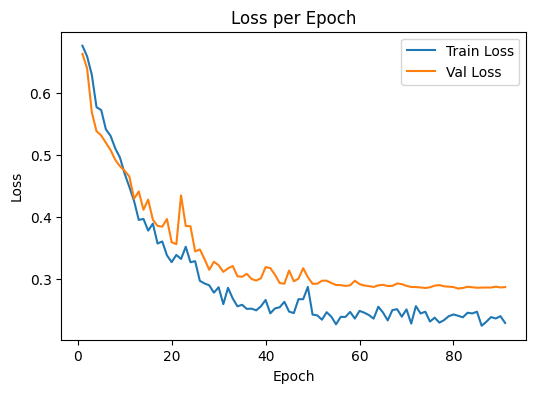

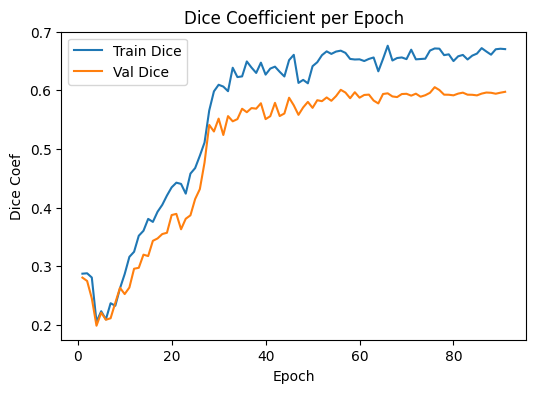

In [23]:
loss      = history.history['loss']
val_loss  = history.history['val_loss']
dice      = history.history['dice_coef']
val_dice  = history.history['val_dice_coef']
epochs    = range(1, len(loss) + 1)

# Plot Loss
plt.figure(figsize=(6,4))
plt.plot(epochs, loss,     label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

# Plot Dice Coefficient
plt.figure(figsize=(6,4))
plt.plot(epochs, dice,     label='Train Dice')
plt.plot(epochs, val_dice, label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Coef')
plt.legend()
plt.title('Dice Coefficient per Epoch')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


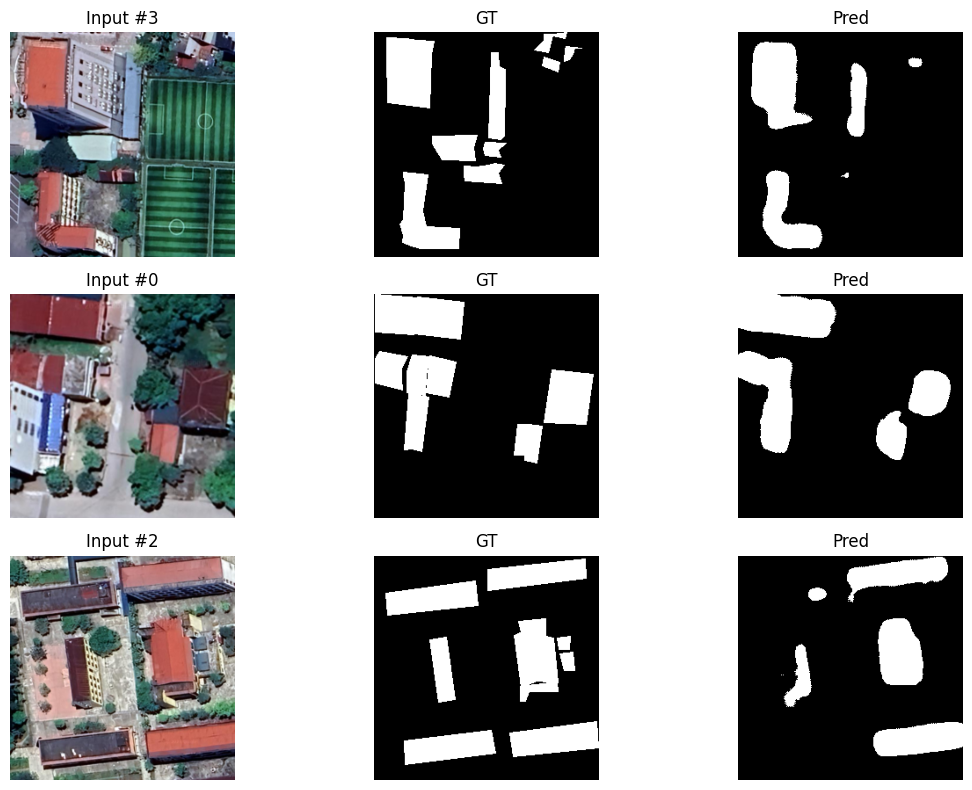

In [29]:
batch_idx = random.randint(0, len(val_gen)-1)
x_batch, y_batch = val_gen[batch_idx]
y_pred = model.predict(x_batch) > 0.5
n = x_batch.shape[0]
sample_indices = random.sample(range(n), 3)
plt.figure(figsize=(12, 8))
for i, idx in enumerate(sample_indices):
    plt.subplot(3, 3, 1 + 3*i)
    plt.imshow(x_batch[idx]);
    plt.title(f"Input #{idx}"); plt.axis('off')

    plt.subplot(3, 3, 2 + 3*i)
    plt.imshow(y_batch[idx].squeeze(), cmap='gray');
    plt.title("GT"); plt.axis('off')

    plt.subplot(3, 3, 3 + 3*i)
    plt.imshow(y_pred[idx].squeeze(), cmap='gray');
    plt.title("Pred"); plt.axis('off')

plt.tight_layout()
plt.show()

# Segmentation-models

Để thực hiện chuyển việc học cho mô hình phân đoạn, ở đây em sử dụng mô hình "segmentation_models" có sẵn trên https://segmentation-models.readthedocs.io/en/latest/tutorial.html. Tất cả các quá trình tiền xử lý và transfer learning đều được thực hiện tự động.

In [ ]:
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

# preprocess input to be consistent with the trained network
images_pro = preprocess_input1(images)


# test-train split
X_train, X_test, y_train, y_test = train_test_split(images_pro, labels, test_size = 0.2, random_state = 101)
print(X_train.shape)
print(X_test.shape)

(40, 256, 256, 3)
(10, 256, 256, 3)


# Data Augmentation

Mục đích:

- Tạo ra các phiên bản biến đổi của ảnh/mask gốc để:

- Tăng kích thước tập dữ liệu ảo

- Giúp mô hình học được tính bất biến (invariance) với các biến đổi hình học

- Chống overfitting

Ở đây chúng ta sử dụng 1 hàm để đảm bảo việc từng cặp ảnh sau khi augument được đồng bộ

In [ ]:
seed = 101

image_generate = ImageDataGenerator(
    rotation_range = 90,          # Xoay ngẫu nhiên 0-90 độ
    width_shift_range = 0.3,      # Dịch ngang 30% chiều rộng
    height_shift_range = 0.3,     # Dịch dọc 30% chiều cao
    shear_range = 0.5,            # Biến dạng trượt (shear)
    zoom_range = 0.3,             # Phóng to/thu nhỏ 30%
    horizontal_flip = True,       # Lật ngang
    vertical_flip = True,         # Lật dọc
    fill_mode = 'reflect'         # Cách điền pixel khi biến đổi
)

image_generate.fit(X_train, augment=True, seed=seed)

image_generator = image_generate.flow(X_train, seed=seed) # Tạo batch dữ liệu từ X_train

validate_img_generator = image_generate.flow(X_test, seed=seed) # Tạo batch dữ liệu từ X_test

label_generate = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range = 0.5,
    zoom_range = 0.3,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'reflect',
    preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))

label_generate.fit(y_train, augment=True, seed=seed)

label_generator = label_generate.flow(y_train, seed=seed) # Tạo batch dữ liệu từ y_train

validate_lbl_generator = label_generate.flow(y_test, seed=seed) # Tạo batch dữ liệu từ y_test

def image_mask_generator(image_generator, label_generator):
    train_generator = zip(image_generator, label_generator) # Kết hợp 2 generator
    for (img, mask) in train_generator:
        yield (img, mask) # Trả về 1 tuple (img, mask) từ 2 generator

my_generator = image_mask_generator(image_generator, label_generator)
validation_data = image_mask_generator(validate_img_generator, validate_lbl_generator)

# Huấn luyện mô hình Segmentation sử dụng kiến trúc UNet với BACKBONE Resnet34

Đoạn code dưới đây định nghĩa và huấn luyện mô hình segmentation sử dụng kiến trúc U-Net với backbone là ResNet34 (được xác định trước đó qua biến BACKBONE)

Em sử dụng UNet là kiến trúc phổ biến cho bài toán segmentation, Backbone (resnet34): Mạng CNN làm encoder để trích xuất đặc trưng.

Hàm mất mát bce_jaccard_loss là kết hợp giữa Binary Cross-Entropy (BCE) và Jaccard Loss (IoU Loss):
$$\text{Loss} = \text{BCE} + (1 - \text{IoU})$$
Cho từng pixel, công thức BCE như sau:
$$
BCE = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(p_i) + (1 - y_i) \cdot \log(1 - p_i) \right]
$$

- \( y_i \): Giá trị thực của pixel (0 hoặc 1).  
- \( p_i \): Xác suất dự đoán pixel thuộc lớp 1 (trong khoảng \([0,1]\)).  
- \( N \): Tổng số pixel.  
Công thức tính chỉ số IoU đo độ chính xác vùng chồng lấn:
$$
IoU = \frac{\text{Predicted Mask} \cap \text{Ground Truth}}{\text{Predicted Mask} \cup \text{Ground Truth}}
$$

- **Giá trị IoU nằm trong khoảng [0, 1]:**
  - **0**: Dự đoán hoàn toàn sai (không có sự chồng lắp).
  - **1**: Dự đoán trùng khớp hoàn hảo với Ground Truth.


In [ ]:
model = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet'  # Sử dụng trọng số pretrained từ ImageNet
)
model.compile(
    optimizer='Adam',
    loss=sm.losses.bce_jaccard_loss,  # Kết hợp BCE và Jaccard Loss
    metrics=[sm.metrics.iou_score]    # Theo dõi IoU trong quá trình train
)

filepath_best_model = project_path + "best_roof_model.h5"

# Tạo callback ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath=filepath_best_model,
    monitor='val_iou_score',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
print(f"Model tốt nhất sẽ được lưu tại: {filepath_best_model}")

# print(model.summary())

# Training the model
history = model.fit(
    my_generator,
    validation_data=validation_data,
    steps_per_epoch = 50, # Số batch mỗi epoch (tập train)
    validation_steps = 50, # Số batch validation mỗi epoch
    epochs=80,
    callbacks=[checkpoint_callback]  # Thêm callback vào quá trình train
)

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model tốt nhất sẽ được lưu tại: /content/drive/MyDrive/Colab Notebooks/best_roof_model.h5
Epoch 1/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - iou_score: 0.3470 - loss: 1.1836
Epoch 1: val_iou_score improved from -inf to 0.18960, saving model to /content/drive/MyDrive/Colab Notebooks/best_roof_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - iou_score: 0.3488 - loss: 1.1790 - val_iou_score: 0.1896 - val_loss: 2.1441
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - iou_score: 0.5419 - loss: 0.8515
Epoch 2: val_iou_score did not improve from 0.18960
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 699ms/step - iou_score: 0.5427 - loss: 0.8487 - val_iou_score: 0.1116 - val_loss: 1.4206
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - iou_score: 0.5306 - loss: 0.9268
Epoch 3: val_iou_score did not improve from 0.18960
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 797ms/step - iou_score: 0.5320 - loss: 0.9227 - val_iou_score: 0.0737 - val_loss: 1.4817
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - iou_score: 0.6083 - loss: 0.6929
Epoch 4: val_iou_score did not improve from 0.18960
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 849ms/step - iou_score: 0.6088 - loss: 0.6918 - val_iou_score: 0.0151 - val_loss: 1.8550
Epoch 5/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - iou_score: 0.6803 - loss: 0.5742
Epoch 5: val_iou_s

50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 776ms/step - iou_score: 0.3960 - loss: 1.3000 - val_iou_score: 0.2419 - val_loss: 1.0971
Epoch 22/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - iou_score: 0.6198 - loss: 0.5970
Epoch 22: val_iou_score improved from 0.24194 to 0.34398, saving model to /content/drive/MyDrive/Colab Notebooks/best_roof_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 924ms/step - iou_score: 0.6207 - loss: 0.5961 - val_iou_score: 0.3440 - val_loss: 1.1378
Epoch 23/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - iou_score: 0.6919 - loss: 0.5437
Epoch 23: val_iou_score did not improve from 0.34398
50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 726ms/step - iou_score: 0.6915 - loss: 0.5449 - val_iou_score: 0.2195 - val_loss: 1.4341
Epoch 24/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - iou_score: 0.6060 - loss: 0.8060
Epoch 24: val_iou_score did not improve from 0.34398
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 632ms/step - iou_score: 0.6039 - loss: 0.8103 - val_iou_score: 0.1694 - val_loss: 1.5306
Epoch 25/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - iou_score: 0.3654 - loss: 1.2666
Epoch 25: val_iou_score did not improve from 0.34398
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 642ms/step - iou_score: 0.3640 - loss: 1.2679 - val_iou_score: 0.1602 - val_loss: 1.3984
Epoch 26/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - iou_score: 0.3336 - loss: 1.2536
Epoch 26:

50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 819ms/step - iou_score: 0.3332 - loss: 1.2537 - val_iou_score: 0.4662 - val_loss: 0.7599
Epoch 27/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - iou_score: 0.6123 - loss: 0.5845
Epoch 27: val_iou_score did not improve from 0.46620
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 685ms/step - iou_score: 0.6134 - loss: 0.5832 - val_iou_score: 0.1621 - val_loss: 1.9175
Epoch 28/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - iou_score: 0.3232 - loss: 1.4814
Epoch 28: val_iou_score did not improve from 0.46620
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 635ms/step - iou_score: 0.3224 - loss: 1.4799 - val_iou_score: 0.1710 - val_loss: 1.4171
Epoch 29/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - iou_score: 0.3015 - loss: 1.3294
Epoch 29: val_iou_score did not improve from 0.46620
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 652ms/step - iou_score: 0.3021 - loss: 1.3274 - val_iou_score: 0.1857 - val_loss: 1.4569
Epoch 30/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - iou_score: 0.2797 - loss: 1.4116
Epoch 30:

50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 842ms/step - iou_score: 0.3471 - loss: 1.4778 - val_iou_score: 0.5387 - val_loss: 0.6937
Epoch 45/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - iou_score: 0.3452 - loss: 1.3445
Epoch 45: val_iou_score did not improve from 0.53870
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 754ms/step - iou_score: 0.3481 - loss: 1.3362 - val_iou_score: 0.4431 - val_loss: 1.0145
Epoch 46/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - iou_score: 0.7028 - loss: 0.4567
Epoch 46: val_iou_score improved from 0.53870 to 0.62884, saving model to /content/drive/MyDrive/Colab Notebooks/best_roof_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 979ms/step - iou_score: 0.7032 - loss: 0.4563 - val_iou_score: 0.6288 - val_loss: 0.6096
Epoch 47/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - iou_score: 0.5410 - loss: 1.0797
Epoch 47: val_iou_score did not improve from 0.62884
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 686ms/step - iou_score: 0.5423 - loss: 1.0746 - val_iou_score: 0.1966 - val_loss: 1.6545
Epoch 48/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - iou_score: 0.7177 - loss: 0.5024
Epoch 48: val_iou_score did not improve from 0.62884
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 709ms/step - iou_score: 0.7151 - loss: 0.5106 - val_iou_score: 0.3200 - val_loss: 1.3700
Epoch 49/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - iou_score: 0.3955 - loss: 1.2502
Epoch 49: val_iou_score did not improve from 0.62884
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 629ms/step - iou_score: 0.3982 - loss: 1.2422 - val_iou_score: 0.1986 - val_loss: 1.6491
Epoch 50/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - iou_score: 0.3859 - loss: 1.3286
Epoch 50:

50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - iou_score: 0.3458 - loss: 1.3871 - val_iou_score: 0.6486 - val_loss: 0.5316
Epoch 54/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - iou_score: 0.6864 - loss: 0.5525
Epoch 54: val_iou_score did not improve from 0.64862
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 736ms/step - iou_score: 0.6868 - loss: 0.5515 - val_iou_score: 0.2559 - val_loss: 1.5959
Epoch 55/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - iou_score: 0.7647 - loss: 0.3901
Epoch 55: val_iou_score did not improve from 0.64862
50/50 ━━━━━━━━━━━━━━━━━━━━ 34s 687ms/step - iou_score: 0.7634 - loss: 0.3944 - val_iou_score: 0.6208 - val_loss: 0.6166
Epoch 56/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - iou_score: 0.3195 - loss: 1.5461
Epoch 56: val_iou_score did not improve from 0.64862
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 630ms/step - iou_score: 0.3225 - loss: 1.5359 - val_iou_score: 0.2057 - val_loss: 1.5674
Epoch 57/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - iou_score: 0.6892 - loss: 0.5420
Epoch 57: va

50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 962ms/step - iou_score: 0.7744 - loss: 0.4259 - val_iou_score: 0.6656 - val_loss: 0.5672
Epoch 62/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - iou_score: 0.7789 - loss: 0.4216
Epoch 62: val_iou_score did not improve from 0.66564
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 699ms/step - iou_score: 0.7789 - loss: 0.4214 - val_iou_score: 0.1797 - val_loss: 2.0214
Epoch 63/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - iou_score: 0.7790 - loss: 0.3996
Epoch 63: val_iou_score did not improve from 0.66564
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 633ms/step - iou_score: 0.7766 - loss: 0.4079 - val_iou_score: 0.2117 - val_loss: 1.6771
Epoch 64/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - iou_score: 0.3090 - loss: 1.5339
Epoch 64: val_iou_score did not improve from 0.66564
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 631ms/step - iou_score: 0.3099 - loss: 1.5296 - val_iou_score: 0.1873 - val_loss: 1.5776
Epoch 65/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - iou_score: 0.2923 - loss: 1.3200
Epoch 65:

Những vấn đề hiện tại
- Thời gian/epoch quá lâu (15p/epoch) -> Tăng batch_size hoặc đảm bảo GPU
- Validation loss tăng -> Thử giảm learning rate (đang mặc định là 1e-3)
- Overfitting (IoU train cao nhưng val thấp) -> Thêm Regularizationv, augmentation mạnh hơn, Early Stopping


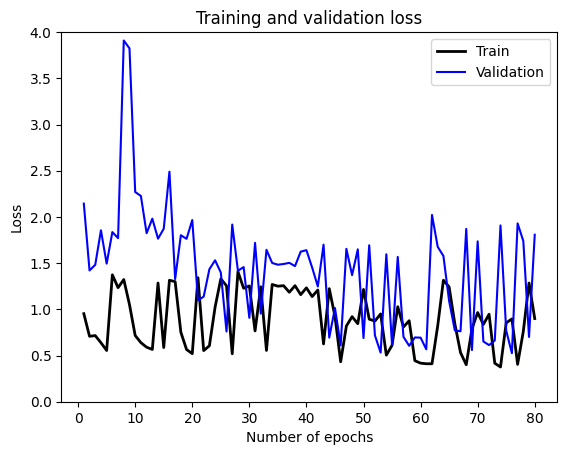

In [ ]:
train_loss = history.history['loss']
validation_loss = history.history['val_loss']
number_epochs = range(1, len(train_loss) + 1)

plt.plot(number_epochs, train_loss, 'k', lw=2, label='Train')
plt.plot(number_epochs, validation_loss, 'b', label='Validation')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.ylim(0,4)
plt.legend()
plt.show()

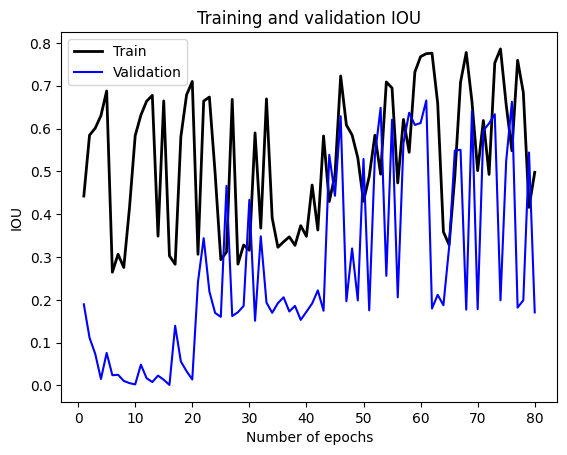

In [ ]:
iou_score = history.history['iou_score']
validation_iou_score = history.history['val_iou_score']

plt.plot(number_epochs, iou_score, 'k', lw=2, label='Train')
plt.plot(number_epochs, validation_iou_score, 'b', label='Validation')
plt.title('Training and validation IOU')
plt.xlabel('Number of epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
IoU socre is:  0.7190381861752246
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


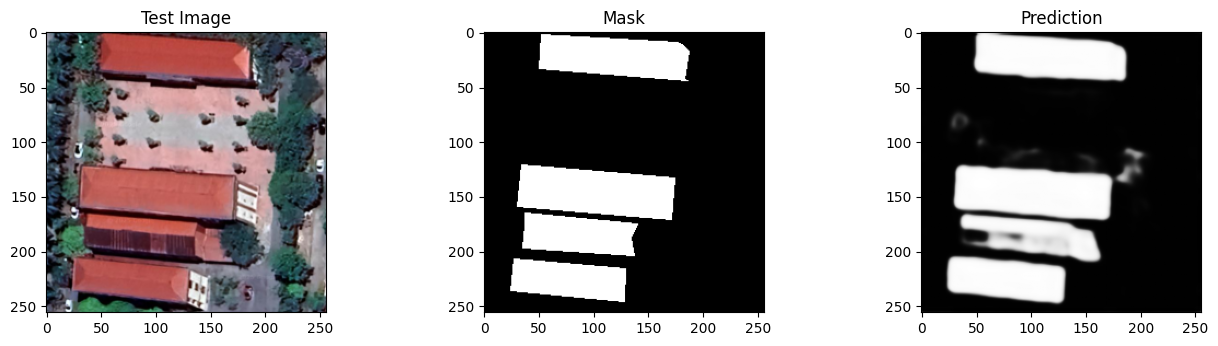

<Figure size 640x480 with 0 Axes>

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

N = random.randint(0, len(X_test)-1)
prediction = model.predict(np.expand_dims(X_test[N],0))


plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Test Image')
plt.imshow(X_test[N])
plt.subplot(232)
plt.title('Mask')
plt.imshow(y_test[N], cmap='gray')
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction[0], cmap='gray')

plt.show()

plt.savefig("test.pdf")

những ảnh có nhiều cây vướng vào mái:
06, 16, 18, 26, 27, 28, 32, 37, 38, 39, 40, 42, 44, 47,
nhiều mái
09, 10, 20, 21, 24, 29, 34, 41, 43, 46, 49, 50.